In [1]:
import matplotlib
fontsize = 17
ticklen = 5
params = {
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': r'''\usepackage{fontspec}
    \setmainfont{Linux Libertine O}''',
    'xtick.major.size' : ticklen,
    'ytick.major.size' : ticklen,
    'xtick.minor.size' : ticklen/2,
    'ytick.minor.size' : ticklen/2
}
matplotlib.rcParams.update(params)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import decimal
import re

import astropy.constants as const
from astropy.table import Table, Column
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd

In [4]:
def compute_T0(planet):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.mean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.mean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.mean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.mean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    nIters = 10000
    Tstar = np.random.normal(Tstar, Tstar_err, nIters)
    a = np.random.normal(a, a_err, nIters)
    
    T0 = Tstar*np.sqrt(1/a)
    return np.array([np.median(T0), np.std(T0)])

In [5]:
mainpath   = '/media/WindowsAndUbuntu/MEGA/'#'/home/taylor/Documents/Research/spitzer/MEGA/'
planets = np.array(['XO-3b_a', 'XO-3b_b', 'XO-3b_c', 'XO-3b_d', 'XO-3b_e', 'XO-3b_f', 'XO-3b_g', 'XO-3b_h', 'XO-3b_i', 'XO-3b_j'])
channels = ['ch2' for planet in planets]
temp_planets = ['_{'.join(planet.split('_'))+'}' if '_' in planet else planet for planet in planets]
fancy_planets = [r'$\rm '+planet.split('_')[-1]+'$' for planet in planets]
twoLimits = True

In [6]:
plotModes = ['Poly2_v1_autoRun', 'Poly2_v1_PSFX_autoRun', 'Poly3_v1_autoRun', 'Poly3_v1_PSFX_autoRun', 'Poly4_v1_autoRun', 'Poly4_v1_PSFX_autoRun', 'Poly5_v1_autoRun', 'Poly5_v1_PSFX_autoRun', 'BLISS_v1_autoRun_finalPOET', 'BLISS_v1_PSFX_autoRun_finalPOET', 'PLDAper1_3x3_v1_autoRun', 'PLDAper2_3x3_v1_autoRun', 'PLDAper1_5x5_v1_autoRun', 'PLDAper2_5x5_v1_autoRun', 'GP_v1_autoRun', 'GP_v1_PSFX_autoRun']
fancy_labels = ['_'.join(plotMode.split('_')[:-2])+'_PSF' if 'PSFX' in plotMode else '_'.join(plotMode.split('_')[:-1]) if 'PLD' in plotMode else '_'.join(plotMode.split('_')[:-1])+'_FWM' for plotMode in plotModes]
fancy_labels = [r'$\rm '+r'\textunderscore '.join(plotMode.split('_'))+r'$' for plotMode in fancy_labels]

In [7]:
# Precomputing irradiation temperatures since this is a slow part due to the MC
T0s_saved = compute_T0(planets[0])

In [8]:
T0s_MEGA = []
As_MEGA = []
Bs_MEGA = []
fps_MEGA = []
offsets_MEGA = []
rps_MEGA = []
tNights_MEGA = []
tDays_MEGA = []
sigFs_MEGA = []
sigF_photons_MEGA = []
sigFs_unBinned_MEGA = []
sigF_photons_unBinned_MEGA = []
modeBICs_MEGA = []
folders_MEGA = []

for i in range(len(plotModes)):
    plotMode = plotModes[i]

    T0s = []
    As = []
    Bs = []
    fps = []
    offsets = []
    rps = []
    tNights = []
    tDays = []
    sigFs = []
    sigF_photons = []
    sigFs_unBinned = []
    sigF_photons_unBinned = []
    modeBICs = []
    folders = []

    for iterNum in range(len(planets)):
        channel = channels[iterNum]
        planet = planets[iterNum]

        # Figure out where files are saved
        phoption = ''
        foldername = ''
        rms = None
        with open(f'{mainpath}{planet}/analysis/{channel}/bestPhOption.txt') as f:
            lines = f.readlines()
        for i in range(len(lines)):
            if phoption=='' and lines[i][0]=='/':
                foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                phoption = lines[i].split('/')[-1].strip()
                i += 1
                ignoreFrames = np.array(lines[i].strip().split('=')[1].strip().replace(' ','').split(','))
                if np.all(ignoreFrames==['']):
                    ignoreFrames = np.array([]).astype(int)
                else:
                    ignoreFrames = ignoreFrames.astype(int)
                i += 1
                rms = float(lines[i])
            elif phoption!='' and lines[i][0]=='/':
                if float(lines[i+2]) < rms:
                    foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                    phoption = lines[i].split('/')[-1].strip()
                    i += 1
                    ignoreFrames = np.array(lines[i].split('=')[1].strip().replace(' ','').split(','))
                    if np.all(ignoreFrames==['']):
                        ignoreFrames = np.array([]).astype(int)
                    else:
                        ignoreFrames = ignoreFrames.astype(int)
                    i += 1
                    rms = float(lines[i])
                else:
                    i += 3
        pldFoldernames = np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

        # Figure out what modes were run
        modes = np.sort([x[0].split('/')[-1] for x in os.walk(foldername)][1:])
        for i in range(len(pldFoldernames)):
            modes = np.append(modes, np.sort([x[0].split('/')[-1] for x in os.walk(pldFoldernames[i])][1:]))
        
        # If this method was not fully run for this planet+channel, skip it
        if plotMode not in modes:
            print(plotMode, 'not run for', planet, channel)
            T0s.append([np.nan, np.nan])
            As.append([np.nan, np.nan, np.nan])
            Bs.append([np.nan, np.nan, np.nan])
            fps.append([np.nan, np.nan, np.nan])
            offsets.append([np.nan, np.nan, np.nan])
            rps.append([np.nan, np.nan, np.nan])
            tNights.append([np.nan, np.nan, np.nan])
            tDays.append([np.nan, np.nan, np.nan])
            sigFs.append([np.nan, np.nan, np.nan])
            sigF_photons.append(np.nan)
            sigFs_unBinned.append([np.nan, np.nan, np.nan])
            sigF_photons_unBinned.append(np.nan)
            modeBICs.append(np.nan)
            folders.append('None')
            continue

        # Pick out only the relevant modes
        modes = modes[modes==plotMode]

        BICs = []
        for mode in modes:
            if 'PLD' in plotMode:
                if channel=='ch2':
                    folder='4um'
                else:
                    folder='3um'
                if '3x3' in mode:
                    folder += 'PLD_3x3/'
                else:
                    folder += 'PLD_5x5/'
                savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            else:
                savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'

            if not os.path.exists(savepath):
                BICs.append(np.nan)
            else:
                ResultMCMC = np.load(savepath)
                BICs.append(-2*ResultMCMC['evidenceB'][0])

        if np.all(np.isnan(BICs)):
            T0s.append([np.nan, np.nan])
            As.append([np.nan, np.nan, np.nan])
            Bs.append([np.nan, np.nan, np.nan])
            fps.append([np.nan, np.nan, np.nan])
            offsets.append([np.nan, np.nan, np.nan])
            rps.append([np.nan, np.nan, np.nan])
            tNights.append([np.nan, np.nan, np.nan])
            tDays.append([np.nan, np.nan, np.nan])
            sigFs.append([np.nan, np.nan, np.nan])
            sigF_photons.append(np.nan)
            sigFs_unBinned.append([np.nan, np.nan, np.nan])
            sigF_photons_unBinned.append(np.nan)
            modeBICs.append(np.nan)
            folders.append('None')
            continue
                
        mode = modes[np.nanargmin(BICs)]

        if 'PLD' in plotMode:
            if channel=='ch2':
                folder='4um'
            else:
                folder='3um'
            if '3x3' in mode:
                folder += 'PLD_3x3/'
            else:
                folder += 'PLD_5x5/'
            savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
        else:
            savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'

        ResultMCMC = np.load(savepath)
        
        T0s.append(T0s_saved)
        fps.append(ResultMCMC['fp']*1e6)
        offsets.append(ResultMCMC['offset'])
        rps.append(ResultMCMC['rp'])
        tNights.append(ResultMCMC['tNight'])
        tDays.append(ResultMCMC['tDay'])
        As.append(ResultMCMC['A'])
        Bs.append(ResultMCMC['B'])
        sigFs.append(ResultMCMC['sigF']*1e6)
        sigF_photons.append(ResultMCMC['sigF_photon_ppm'][0])
        
        if not 'GP' in mode:
            ndata = ResultMCMC['chi2B']/ResultMCMC['chi2datum']*64
            sigFs_unBinned.append(ResultMCMC['sigF']*1e6*np.sqrt(64)*np.sqrt(ResultMCMC['chi2']/ndata))
            sigF_photons_unBinned.append(ResultMCMC['sigF_photon_ppm'][0]*np.sqrt(64))
        else:
            sigFs_unBinned.append([np.nan, np.nan, np.nan])
            sigF_photons_unBinned.append(np.nan)
        
        modeBICs.append(BICs[np.nanargmin(BICs)])
        
        folders.append('/'.join(savepath.split('/')[:-1]))

        print(planet, channel, mode)

    T0s = np.array(T0s).T
    As = np.array(As).T
    Bs = np.array(Bs).T
    fps = np.array(fps).T
    offsets = np.array(offsets).T
    rps = np.array(rps).T
    tNights = np.array(tNights).T
    tDays = np.array(tDays).T
    sigFs = np.array(sigFs).T
    sigF_photons = np.array(sigF_photons)
    sigFs_unBinned = np.array(sigFs_unBinned).T
    sigF_photons_unBinned = np.array(sigF_photons_unBinned)
    modeBICs = np.array(modeBICs)
    folders = np.array(folders)

    T0s_MEGA.append(T0s)
    As_MEGA.append(As)
    Bs_MEGA.append(Bs)
    fps_MEGA.append(fps)
    offsets_MEGA.append(offsets)
    rps_MEGA.append(rps)
    tNights_MEGA.append(tNights)
    tDays_MEGA.append(tDays)
    sigFs_MEGA.append(sigFs)
    sigF_photons_MEGA.append(sigF_photons)
    sigFs_unBinned_MEGA.append(sigFs_unBinned)
    sigF_photons_unBinned_MEGA.append(sigF_photons_unBinned)
    modeBICs_MEGA.append(modeBICs)
    folders_MEGA.append(folders)
    
T0s_MEGA = np.array(T0s_MEGA)
As_MEGA = np.array(As_MEGA)
Bs_MEGA = np.array(Bs_MEGA)
fps_MEGA = np.array(fps_MEGA)
offsets_MEGA = np.array(offsets_MEGA)
rps_MEGA = np.array(rps_MEGA)
tNights_MEGA = np.array(tNights_MEGA)
tDays_MEGA = np.array(tDays_MEGA)
sigFs_MEGA = np.array(sigFs_MEGA)
sigF_photons_MEGA = np.array(sigF_photons_MEGA)
sigFs_unBinned_MEGA = np.array(sigFs_unBinned_MEGA)
sigF_photons_unBinned_MEGA = np.array(sigF_photons_unBinned_MEGA)
modeBICs_MEGA = np.array(modeBICs_MEGA)
folders_MEGA = np.array(folders_MEGA)
planets = np.array(planets)
fancy_planets = np.array(fancy_planets)

XO-3b_a ch2 Poly2_v1_autoRun
XO-3b_b ch2 Poly2_v1_autoRun
XO-3b_c ch2 Poly2_v1_autoRun
XO-3b_d ch2 Poly2_v1_autoRun
XO-3b_e ch2 Poly2_v1_autoRun
XO-3b_f ch2 Poly2_v1_autoRun
XO-3b_g ch2 Poly2_v1_autoRun
XO-3b_h ch2 Poly2_v1_autoRun
XO-3b_i ch2 Poly2_v1_autoRun
XO-3b_j ch2 Poly2_v1_autoRun
XO-3b_a ch2 Poly2_v1_PSFX_autoRun
XO-3b_b ch2 Poly2_v1_PSFX_autoRun
XO-3b_c ch2 Poly2_v1_PSFX_autoRun
XO-3b_d ch2 Poly2_v1_PSFX_autoRun
XO-3b_e ch2 Poly2_v1_PSFX_autoRun
XO-3b_f ch2 Poly2_v1_PSFX_autoRun
XO-3b_g ch2 Poly2_v1_PSFX_autoRun
XO-3b_h ch2 Poly2_v1_PSFX_autoRun
XO-3b_i ch2 Poly2_v1_PSFX_autoRun
XO-3b_j ch2 Poly2_v1_PSFX_autoRun
XO-3b_a ch2 Poly3_v1_autoRun
XO-3b_b ch2 Poly3_v1_autoRun
XO-3b_c ch2 Poly3_v1_autoRun
XO-3b_d ch2 Poly3_v1_autoRun
XO-3b_e ch2 Poly3_v1_autoRun
XO-3b_f ch2 Poly3_v1_autoRun
XO-3b_g ch2 Poly3_v1_autoRun
XO-3b_h ch2 Poly3_v1_autoRun
XO-3b_i ch2 Poly3_v1_autoRun
XO-3b_j ch2 Poly3_v1_autoRun
XO-3b_a ch2 Poly3_v1_PSFX_autoRun
XO-3b_b ch2 Poly3_v1_PSFX_autoRun
XO-3b_c ch2 

In [9]:
D_bars = []
sig_bars = []
SDs = []
sig_origs = []
f_diss = []
sig_TOTs = []
Rs = []
rs = []
a_s = []

truth = 1520#np.median(fps_MEGA[:,0,:])
SNR = np.mean(1/(sigF_photons_MEGA[i]/1e6))
f_in = 1/3.
D = truth/1e6
N = ndata[0]/64
sig_phot = np.sqrt((1+D)**2/(N*SNR**2) * (1/((1-f_in)*(1+D)) + 1/f_in))*1e6
#sig_phot = 53

print(format('Mode', '23s')+' |  ', '  '.join(['Dbar', 'sbr', 'SD ', 's ', 'fd ', 'sT', 'R  ', 'r   ', 'a   ']))
print(''.join(['-' for i in range(73)]))
for i in range(len(plotModes)):
    D_i = fps_MEGA[i][0]
    sig_i = np.mean(fps_MEGA[i][1:], axis=0)
    w_i = 1/sig_i**2
    N = fps_MEGA.shape[-1]
    mode = format(re.sub('_finalPOET', '', plotModes[i]), '23s')
    
    D_bar = np.sum(D_i*w_i)/np.sum(w_i)
    sig_bar = np.mean(sig_i)
    SD = np.std(D_i)
    sig_orig = np.sqrt(1/np.sum(w_i))
    
    f_dis = np.sqrt(np.sum((D_i-D_bar)**2/(sig_i**2*(N-1))))
    w_i = 1/(f_dis**2*sig_i**2)
    sig_TOT = np.sqrt(1/np.sum(w_i))
    
    Delta_ij = fps_MEGA[i][0]-fps_MEGA[i][0][np.repeat(np.arange(fps_MEGA.shape[2]).reshape(-1,1), fps_MEGA.shape[2], axis=1)]
    R = np.std(Delta_ij)
    
    r = sig_phot/SD
    
    a = sig_phot/np.sqrt(np.mean((D_i-truth)**2))
    
    D_bars.append(D_bar)
    sig_bars.append(sig_bar)
    SDs.append(SD)
    sig_origs.append(sig_orig)
    f_diss.append(f_dis)
    sig_TOTs.append(sig_TOT)
    Rs.append(R)
    rs.append(r)
    a_s.append(a)
    
    vals = [D_bar, sig_bar, SD, sig_orig, f_dis, sig_TOT, R, r, a]
    for j in [0,1,2,3,5,6]:
        vals[j] = str(int(np.round(vals[j])))
    vals[5] = format(vals[5], '2s')
    vals[4] = format(np.round(vals[4], 1), '0.1f')
    vals[7] = format(np.round(vals[7], 2), '0.2f')
    vals[8] = format(np.round(vals[8], 2), '0.2f')
    
    print(mode+' |  ', '  '.join(vals))

print(''.join(['-' for i in range(73)]))
vals = list(np.array([D_bars, sig_bars, SDs, sig_origs, f_diss, sig_TOTs, Rs, rs, a_s]).mean(axis=1))
for j in [0,1,2,3,5,6]:
    vals[j] = str(int(np.round(vals[j])))
vals[5] = format(vals[5], '2s')
vals[4] = format(np.round(vals[4], 1), '0.1f')
vals[7] = format(np.round(vals[7], 2), '0.2f')
vals[8] = format(np.round(vals[8], 2), '0.2f')
print(format('Average', '23s')+' |  ', '  '.join(vals))

D_bars = np.array(D_bars)
sig_bars = np.array(sig_bars)
SDs = np.array(SDs)
sig_origs = np.array(sig_origs)
f_diss = np.array(f_diss)
sig_TOTs = np.array(sig_TOTs)
Rs = np.array(Rs)
rs = np.array(rs)
a_s = np.array(a_s)

Mode                    |   Dbar  sbr  SD   s   fd   sT  R    r     a   
-------------------------------------------------------------------------
Poly2_v1_autoRun        |   1480  120  153  37  1.4  51  216  0.42  0.41
Poly2_v1_PSFX_autoRun   |   1500  118  145  37  1.3  48  205  0.44  0.44
Poly3_v1_autoRun        |   1485  120  158  37  1.4  53  223  0.41  0.40
Poly3_v1_PSFX_autoRun   |   1496  123  156  38  1.4  51  221  0.41  0.41
Poly4_v1_autoRun        |   1455  125  157  38  1.3  51  221  0.41  0.39
Poly4_v1_PSFX_autoRun   |   1490  126  202  39  1.7  65  285  0.32  0.31
Poly5_v1_autoRun        |   1483  136  192  42  1.5  65  271  0.33  0.33
Poly5_v1_PSFX_autoRun   |   1494  139  198  43  1.6  66  280  0.32  0.32
BLISS_v1_autoRun        |   1490  121  155  37  1.4  51  219  0.41  0.41
BLISS_v1_PSFX_autoRun   |   1476  123  158  38  1.4  52  224  0.40  0.39
PLDAper1_3x3_v1_autoRun |   1492  120  151  37  1.3  50  213  0.42  0.42
PLDAper2_3x3_v1_autoRun |   1549  127  170  39  1.

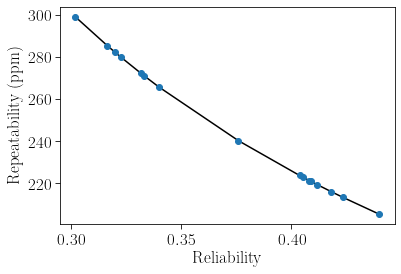

In [10]:
order = np.argsort(rs)
plt.plot(rs[order], sig_phot*np.sqrt(2)/rs[order], c='k')
plt.plot(rs[order], Rs[order], 'o')
plt.ylabel(r'$\rm Repeatability~(ppm)$')
plt.xlabel(r'$\rm Reliability$')
plt.show()

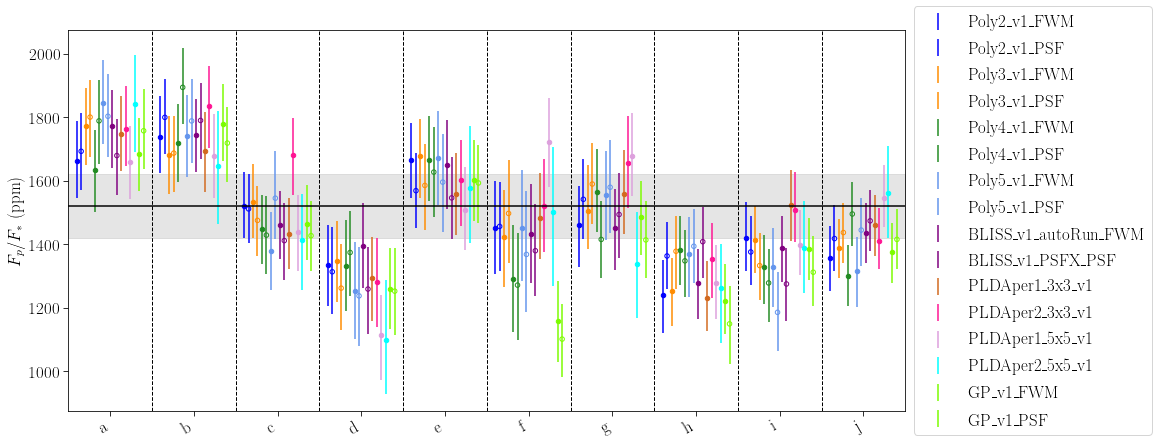

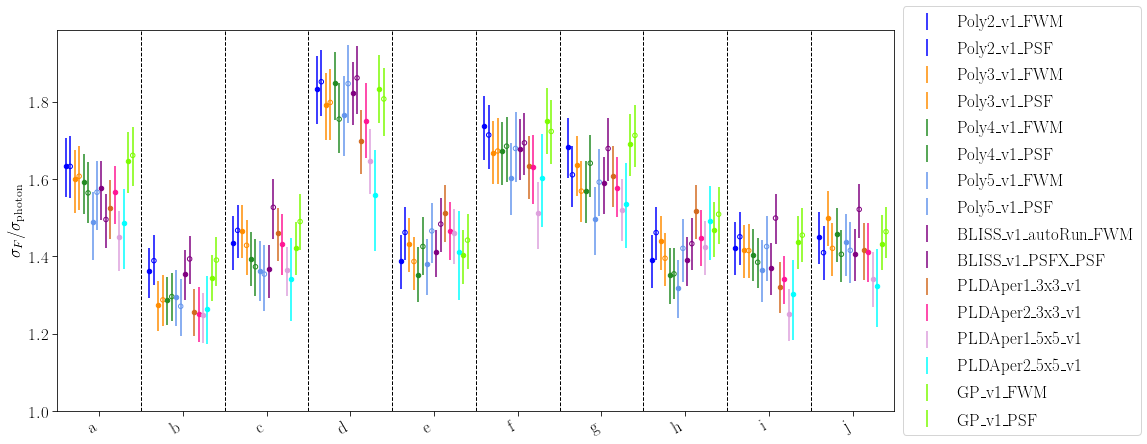

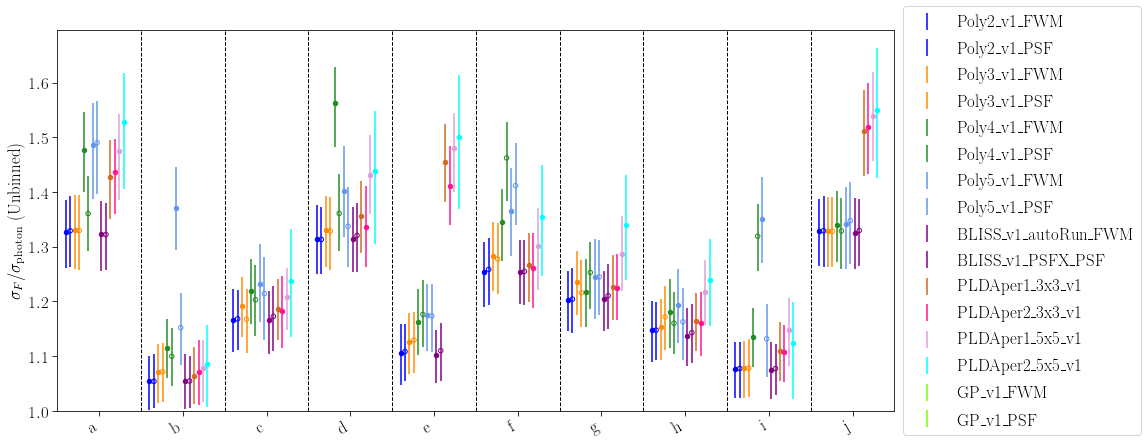

In [12]:
colors = ['blue', 'blue', 'darkorange', 'darkorange', 'forestgreen', 'forestgreen',
          'cornflowerblue', 'cornflowerblue', 'purple', 'purple', 'chocolate',
          'deeppink', 'plum', 'cyan', 'lawngreen', 'lawngreen']

plt.figure(figsize=(15,7))
plt.plot([-0.5,T0s_MEGA[0][0].size-0.5], [1520, 1520], c='k')
plt.fill_between([-0.5,T0s_MEGA[0][0].size-0.5], [1520-102, 1520-102], [1520+102, 1520+102], color='grey', alpha=0.2)
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = np.linspace(0.0, 0.8, len(plotModes))
    xoffset -= np.median(xoffset)
    xoffset = xoffset[i]
    plt.errorbar(np.arange(len(planets))+xoffset, fps_MEGA[i][0], yerr=fps_MEGA[i][1:], fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(np.arange(len(planets))+xoffset, fps_MEGA[i][0], marker='o', facecolors=[colors[i], ''][i%2 if i<10 else i%2 if i>13 else 0], edgecolors=colors[i], s=20)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'$F_p/F_*~({\rm ppm})$')
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig(mainpath+'figures/XO3b_fday.pdf', bbox_inches='tight')
plt.show()




plt.figure(figsize=(15,7))
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = np.linspace(0.0, 0.8, len(plotModes))
    xoffset -= np.median(xoffset)
    xoffset = xoffset[i]
    plt.errorbar(np.arange(len(planets))+xoffset, sigFs_MEGA[i][0]/sigF_photons_MEGA[i], yerr=sigFs_MEGA[i][1:]/sigF_photons_MEGA[i], fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(np.arange(len(planets))+xoffset, sigFs_MEGA[i][0]/sigF_photons_MEGA[i], marker='o', facecolors=[colors[i], ''][i%2 if i<10 else i%2 if i>13 else 0], edgecolors=colors[i], s=20)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'$\sigma_F/\sigma_{\rm photon}$')
plt.ylim(1)
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig(mainpath+'figures/XO3b_noise.pdf', bbox_inches='tight')
plt.show()




plt.figure(figsize=(15,7))
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = np.linspace(0.0, 0.8, len(plotModes))
    xoffset -= np.median(xoffset)
    xoffset = xoffset[i]
    plt.errorbar(np.arange(len(planets))+xoffset, sigFs_unBinned_MEGA[i][0]/sigF_photons_unBinned_MEGA[i], yerr=sigFs_unBinned_MEGA[i][1:]/sigF_photons_unBinned_MEGA[i], fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(np.arange(len(planets))+xoffset, sigFs_unBinned_MEGA[i][0]/sigF_photons_unBinned_MEGA[i], marker='o', facecolors=[colors[i], ''][i%2 if i<10 else i%2 if i>13 else 0], edgecolors=colors[i], s=20)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'$\sigma_F/\sigma_{\rm photon}~({\rm Unbinned})$')
plt.ylim(1)
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig(mainpath+'figures/XO3b_unbinned_noise.pdf', bbox_inches='tight')
plt.show()

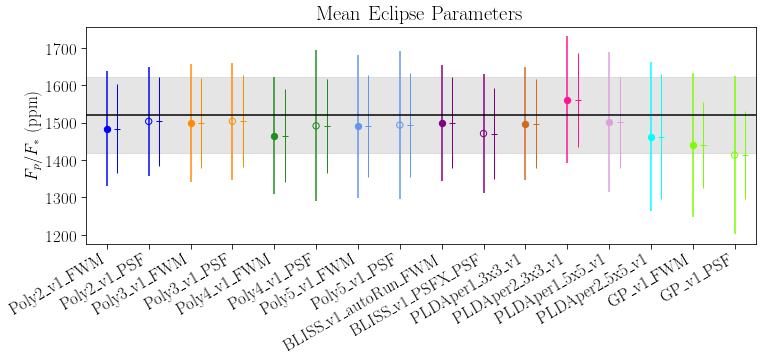

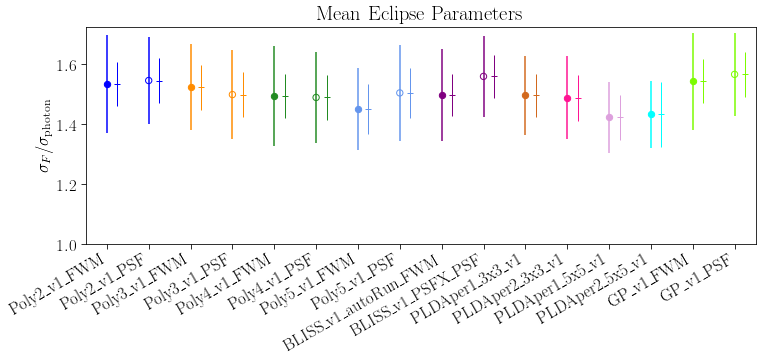

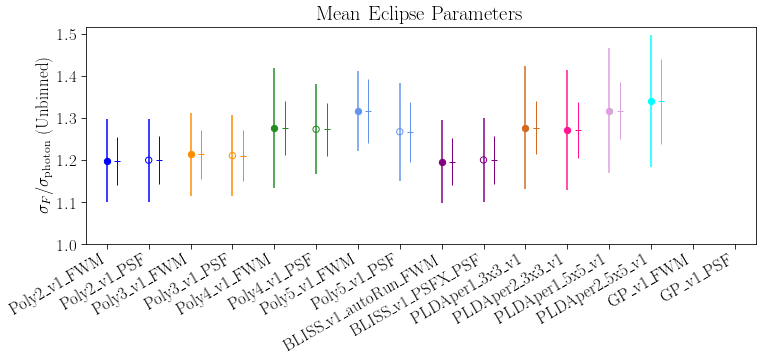

In [28]:
plt.figure(figsize=(12,4))
plt.title(r'$\rm Mean~Eclipse~Parameters$', fontsize=fontsize*1.2)
plt.plot([-0.5,T0s_MEGA.shape[0]-0.5], [1520, 1520], c='k')
plt.fill_between([-0.5,T0s_MEGA.shape[0]-0.5], [1520-102, 1520-102], [1520+102, 1520+102], color='grey', alpha=0.2)

for i in range(len(plotModes)):
    plt.errorbar(i, np.nanmean(fps_MEGA[i,0]), yerr=np.nanstd(fps_MEGA[i,0]), fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(i, np.nanmean(fps_MEGA[i,0]), marker='o', facecolors=[colors[i], ''][i%2 if i<10 else i%2 if i>13 else 0], edgecolors=colors[i], s=40)
    plt.errorbar(i+0.25, np.nanmean(fps_MEGA[i,0]), yerr=np.nanmean(fps_MEGA[i,1:]), fmt='_', color=colors[i], lw=1, label=fancy_labels[i])
plt.xticks(np.arange(len(plotModes)), rotation=30)
plt.gca().set_xticklabels(fancy_labels, ha="right")
plt.ylabel(r'$F_p/F_*~({\rm ppm})$')
plt.xlim(-0.5,len(plotModes)-0.5)
plt.savefig(mainpath+'figures/XO3b_fday_diffs.pdf', bbox_inches='tight')
plt.show()




plt.figure(figsize=(12,4))
plt.title(r'$\rm Mean~Eclipse~Parameters$', fontsize=fontsize*1.2)
for i in range(len(plotModes)):
    plt.errorbar(i, np.nanmean(sigFs_MEGA[i][0]/sigF_photons_MEGA[i]), yerr=np.nanstd(sigFs_MEGA[i][0]/sigF_photons_MEGA[i]), fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(i, np.nanmean(sigFs_MEGA[i][0]/sigF_photons_MEGA[i]), marker='o', facecolors=[colors[i], ''][i%2 if i<10 else i%2 if i>13 else 0], edgecolors=colors[i], s=40)
    plt.errorbar(i+0.25, np.nanmean(sigFs_MEGA[i][0]/sigF_photons_MEGA[i]), yerr=np.nanmean(sigFs_MEGA[i,1:]/sigF_photons_MEGA[i]), fmt='_', color=colors[i], lw=1, label=fancy_labels[i])
plt.xticks(np.arange(len(plotModes)), rotation=30)
plt.gca().set_xticklabels(fancy_labels, ha="right")
plt.ylabel(r'$\sigma_F/\sigma_{\rm photon}$')
plt.ylim(1)
plt.xlim(-0.5,len(plotModes)-0.5)
plt.savefig(mainpath+'figures/XO3b_noise_diffs.pdf', bbox_inches='tight')
plt.show()



plt.figure(figsize=(12,4))
plt.title(r'$\rm Mean~Eclipse~Parameters$', fontsize=fontsize*1.2)
for i in range(len(plotModes)):
    plt.errorbar(i, np.nanmean(sigFs_unBinned_MEGA[i][0]/sigF_photons_unBinned_MEGA[i]), yerr=np.nanstd(sigFs_unBinned_MEGA[i][0]/sigF_photons_unBinned_MEGA[i]), fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(i, np.nanmean(sigFs_unBinned_MEGA[i][0]/sigF_photons_unBinned_MEGA[i]), marker='o', facecolors=[colors[i], ''][i%2 if i<10 else i%2 if i>13 else 0], edgecolors=colors[i], s=40)
    plt.errorbar(i+0.25, np.nanmean(sigFs_unBinned_MEGA[i][0]/sigF_photons_unBinned_MEGA[i]), yerr=np.nanmean(sigFs_unBinned_MEGA[i,1:]/sigF_photons_unBinned_MEGA[i]), fmt='_', color=colors[i], lw=1, label=fancy_labels[i])
plt.xticks(np.arange(len(plotModes)), rotation=30)
plt.gca().set_xticklabels(fancy_labels, ha="right")
plt.ylabel(r'$\sigma_F/\sigma_{\rm photon}~({\rm Unbinned})$')
plt.ylim(1)
plt.xlim(-0.5,len(plotModes)-0.5)
plt.savefig(mainpath+'figures/XO3b_unbinned_noise_diffs.pdf', bbox_inches='tight')
plt.show()

In [31]:
np.std(fps_MEGA[:,0])/np.nanmedian(fps_MEGA[:,1:])

1.4399714091404825

In [32]:
np.nanstd(fps_MEGA[:,0], axis=1)/np.nanmedian(fps_MEGA[:,1:], axis=(1,2))

array([1.28519237, 1.23223761, 1.31079762, 1.28724873, 1.25868317,
       1.63457431, 1.45923075, 1.49549441, 1.33478215, 1.30240735,
       1.25667089, 1.35017916, 1.53023571, 1.19458934, 1.64739453,
       1.77073414])